In [9]:
import torch
import torchvision
import torchvision.transforms as transforms
#Imports all necessary packages for training

In [7]:
#This next line calls the Compose method of the transforms class
#The transforms class contains methods for transforming images and numpy arrays
#The Compose method compounds transformations.
#You add a tuple/list of transformation objects and it composes a new transformation object of the list of transforms

# The image is transformed like so 
# Image ---> ToTensor (normalized from [0,1], ---> Normalize (now normalizes from [-1,1])
# Here is a discussion on the topic https://discuss.pytorch.org/t/understanding-transform-normalize/21730/4

transformation = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])



Files already downloaded and verified


In [15]:
#This line loads the cifar10 dataset into the given 'root' directory, sets the data set's flag to indicate it
#is a training dataset (not a test) and then downloads and adds a transformation to the set.
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,download=True, transform=transformation)

Files already downloaded and verified


In [11]:
#trainloader is now a dataloader object which uses a
#batch size of 4 (it updates the models parameters every 4 images)
# num workers determines how many batches are prepared or loaded before hand
# if num_workers is 0 this means data will be loaded in the main process and not in parallel. 
# Shuffle randomly selects pictures
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,shuffle=True, num_workers=5)

In [13]:
#This is the same as the last two cell. The only difference is that this is the test data or the 
# data which will verify the accuracy of our trained model.
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transformation)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=5)


Files already downloaded and verified


In [16]:
#Defines a tuple of classes to be classified from the data set
classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

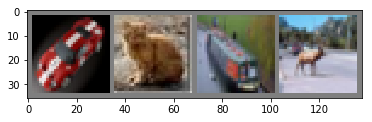

  car   cat  ship  deer


In [29]:
# Let us show some of the training images, for fun.

import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [30]:
########################################################################
# 2. Define a Convolutional Neural Network
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
# Copy the neural network from the Neural Networks section before and modify it to
# take 3-channel images (instead of 1-channel images as it was defined).

import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()